In [392]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, KFold

# Data Generating

In [393]:
RNG = np.random.default_rng(seed=1)
n_features = 10
n_samples = 50
var = 1
cov = var*np.eye(n_features)
mean = np.zeros(n_features)
sigma = 1

# To define the weights as beta
beta = np.array([0, 0, 0, 1, 1, 1, 0, 1, 1, 1])

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n_samples)
y = x@beta + RNG.normal(0, sigma**2, size=n_samples)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Least Square Estimation

In [394]:
def leastsquare(x, y):
    return np.linalg.solve(x.T.dot(x), x.T.dot(y))

ls_beta_hat = leastsquare(x, y)
ls_beta_hat

array([ 0.24609876,  0.01423886, -0.23168091,  1.05382809,  1.06469195,
        1.02579901,  0.19014645,  1.19743133,  0.83758657,  1.07146944])

# Sparsity: L1 Regularization Estimation

In [395]:
# criterion definition
def squared_error(beta, x, y, d):  ## Sum of abs residuals (norm 1)
    beta = np.reshape(beta,(-1, d))
    return np.sum(abs(beta@x.T-y)**2,axis=1)

def L1_lossfunc(beta, alpha, x, y, n_features):
    return squared_error(beta, x, y, n_features) + alpha*np.sum(abs(np.reshape(beta,(-1,n_features))),axis=1)

In [396]:
# optimisation algorithm
def minimizer(lossfunction, alpha, x, y, n_features):   
    initial_beta = np.random.randint(2,size=(n_features))
    result = minimize(lossfunction, initial_beta, method='Powell', args=(alpha, x, y, n_features), tol=1e-8)
    optimized_beta = result.x
    return optimized_beta

# Sparsity: Binary Estimation

In [397]:
# criterion definition
def binary_lossfunc(beta, alpha , x, y, n_features):
  pp = []
  beta = np.reshape(beta,(-1, n_features))
  for i in range((beta.shape)[0]):
    p = []
    for b in beta[i]:
      if b<=0.5:
        p.append(alpha*abs(b))
      else:
        p.append(alpha*abs(b-1))
    pp.append(np.sum(p))
  return squared_error(beta,x , y, n_features)+np.asarray(pp)

# Sample Size Effect

In [398]:
def resampling(reps, x, y, lossfunc, optimizer, alpha):
    beta_hat = []
    beta_estimation_error_per_repitation = []
    std_error_per_samplesize = []
    mean_error_per_samplesize = []
    repitation = reps
    n_samples, n_features = x.shape
    training_size = np.array(range(1,11))*np.divide(n_samples, 10).astype(np.int16)
    for n in training_size:
        for r in range(repitation):
            sample_index = np.random.choice(len(x), n, replace=False)
            sample_size = n
            x_input = x[sample_index]
            y_label = y[sample_index]
            beta_hat.append(optimizer(lossfunc, alpha, x_input, y_label, n_features))
            beta_estimation_error_per_repitation.append(np.sum((beta-beta_hat[-1])**2))
        mean_error_per_samplesize.append(np.mean(beta_estimation_error_per_repitation))
        std_error_per_samplesize.append(np.std(beta_estimation_error_per_repitation))

    return np.array(mean_error_per_samplesize), np.array(std_error_per_samplesize), training_size

In [399]:
repitation = [5, 10, 20]
alpha = 1
binary_beta_estimation_mean_error = []
binary_beta_estimation_std_error = []
l1_beta_estimation_mean_error = []
l1_beta_estimation_std_error = []
for r in repitation:
    binary_result = resampling(r, x, y, binary_lossfunc, minimizer, alpha)
    binary_beta_estimation_mean_error.append(binary_result[0])
    binary_beta_estimation_std_error.append(binary_result[1])
    training_size = binary_result[2]
    l1_result = resampling(r, x, y, L1_lossfunc, minimizer, alpha)
    l1_beta_estimation_mean_error.append(l1_result[0])
    l1_beta_estimation_std_error.append(l1_result[1])

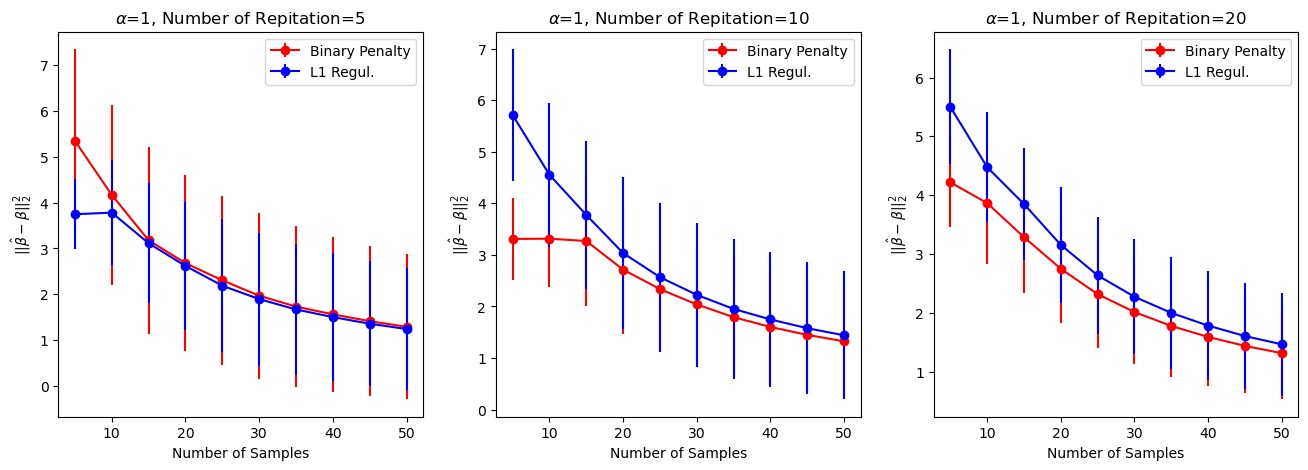

In [404]:

_, axs = plt.subplots(1, len(repitation), figsize=(len(repitation)*5+1, 5))
for ax_id in range(len(repitation)):
    axs[ax_id].errorbar(training_size, binary_beta_estimation_mean_error[ax_id], yerr=binary_beta_estimation_std_error[ax_id]*1.96/(repitation[ax_id]**0.5), marker='o', color = 'red', label='Binary Penalty')
    axs[ax_id].errorbar(training_size, l1_beta_estimation_mean_error[ax_id], yerr=l1_beta_estimation_std_error[ax_id]*1.96/(repitation[ax_id]**0.5), marker='o', color='blue', label='L1 Regul.')
    axs[ax_id].set_xlabel('Number of Samples')
    axs[ax_id].set_ylabel('$||\\hat{\\beta}-\\beta||_{2}^{2}$')
    axs[ax_id].set_title(f'$\\alpha$={alpha}, Number of Repitation={repitation[ax_id]}')
    axs[ax_id].legend()

In [401]:
def binary_round(v):
    v = np.asarray(v)
    bv = []
    for x in v:
        if abs(x) < abs(x-1):
            x = 0
        elif abs(x-1) < abs(x):
            x = 1
        else:
            x = x
        bv.append(x)
    return bv

In [402]:
def CV_minimizer(lossfunc, x, y, alpha, rounding=True):
    kf = KFold(n_splits=5, shuffle=True, random_state=529)
    estimated_beta = []
    sse_valid = []
    d = x.shape[1]
    for train_ind, val_ind in kf.split(x,y):

        X_train = x[train_ind]
        Y_train = y[train_ind]

        X_valid = x[val_ind]
        Y_valid = y[val_ind]
        estimated_beta.append(minimizer(lossfunc, alpha, X_train, Y_train, d))
        # binary_weights = binary_round(estimated_beta[-1])
        if rounding:
            sse_valid.append(squared_error(binary_round(estimated_beta[-1]), X_valid, Y_valid, d))
        else:
            sse_valid.append(squared_error(estimated_beta[-1], X_valid, Y_valid, d))

    return sse_valid

In [403]:
# alpha = [0.1, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean_sse_valid_L1 = []
mean_sse_valid_binary = []
mean_sse_valid_L1_rounded = []
mean_sse_valid_binary_rounded = []
for a in alpha:
    # mean_sse_valid_L1.append(np.mean(CV_minimizer(L1_lossfun, x, y, a, rounding=False)))
    # mean_sse_valid_binary.append(np.mean(CV_minimizer(binary_regularised_error, x, y, a, rounding=False)))
    mean_sse_valid_L1_rounded.append(np.mean(CV_minimizer(L1_lossfun, x, y, a)))
    mean_sse_valid_binary_rounded.append(np.mean(CV_minimizer(binary_lossfunction, x, y, a)))

TypeError: 'int' object is not iterable

In [ ]:
_, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.plot(alpha, mean_sse_valid_L1_rounded, marker='o', color='blue', label='$L_1$ Penalty')
axs.plot(alpha, mean_sse_valid_binary_rounded, marker='*', color='red', label='Binarized Penalty')
axs.set_xlabel('$\\alpha$')
axs.set_ylabel('Mean Squared Error over Validation Data')
axs.set_title('With Rounding the Weights to 0 & 1')
axs.legend()